In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import json
import time
from tqdm import tqdm

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

def format_number(num):
    if num >= 1e6:
        return f'{num/1e6:.2f}M'
    elif num >= 1e3:
        return f'{num/1e3:.2f}K'
    else:
        return str(num)

In [36]:
data_path = '3_data/AP_train.txt'
print("="*50)

# Peek at first few lines to understand format
with open(data_path, 'r', encoding='utf-8', errors='ignore') as f:
    print("First 20 lines of the dataset:")
    for i in range(20):
        line = f.readline()
        if not line:
            break
        print(f"  {line.rstrip()}")

print("\n" + "="*50)
print("Data format markers:")
print("  #* : Paper title")
print("  #@ : Authors (semicolon separated)")
print("  #t : Year")
print("  #c : Venue/Conference")
print("  #index : Paper ID")
print("  #% : Reference (paper ID)")
print("  #! : Abstract")
print("="*50)

def load_aminer_data(filepath, sample_size=None):
    publications = []
    authors_dict = defaultdict(list)
    venues_dict = defaultdict(list)
    citations_dict = defaultdict(int)
    references_dict = defaultdict(list)
    
    print(f"\nLoading dataset from {filepath}...")
    start_time = time.time()
    
    current_pub = {}
    line_count = 0
    
    with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
        for line in tqdm(f, desc="Processing lines"):
            line = line.strip()
            line_count += 1
            
            if sample_size and len(publications) >= sample_size:
                break
            
            if line.startswith('#*'):  # Title
                if current_pub and 'id' in current_pub:
                    publications.append(current_pub)
                current_pub = {'title': line[2:].strip()}
                
            elif line.startswith('#@'):  # Authors
                authors = line[2:].strip().split(';')
                current_pub['authors'] = [a.strip() for a in authors if a.strip()]
                
            elif line.startswith('#t'):  # Year
                try:
                    current_pub['year'] = int(line[2:].strip())
                except:
                    pass
                    
            elif line.startswith('#c'):  # Venue
                current_pub['venue'] = line[2:].strip()
                
            elif line.startswith('#index'):  # Paper ID
                current_pub['id'] = line[6:].strip()
                
            elif line.startswith('#%'):  # Reference
                if 'references' not in current_pub:
                    current_pub['references'] = []
                ref_id = line[2:].strip()
                if ref_id:
                    current_pub['references'].append(ref_id)
                    
            elif line.startswith('#!'):  # Abstract
                current_pub['abstract'] = line[2:].strip()
    
    if current_pub and 'id' in current_pub:
        publications.append(current_pub)
        
    for pub in publications:
        pub_id = pub.get('id', f'pub_{publications.index(pub)}')
        
        # Process authors
        if 'authors' in pub:
            for author in pub['authors']:
                if author:  # Skip empty authors
                    authors_dict[author].append(pub_id)
        
        # Process venue
        venue = pub.get('venue', '')
        if venue and venue != 'Unknown':
            venues_dict[venue].append(pub_id)
        
        # Process references
        if 'references' in pub:
            references_dict[pub_id] = pub['references']
            # Count citations for referenced papers
            for ref_id in pub['references']:
                citations_dict[ref_id] += 1
    
    load_time = time.time() - start_time
    print(f"Loaded {len(publications)} publications in {load_time:.2f} seconds")
    print(f"Total lines processed: {line_count}")
    
    return publications, authors_dict, venues_dict, citations_dict, references_dict
SAMPLE_SIZE = 10000
publications, authors_dict, venues_dict, citations_dict, references_dict = load_aminer_data(
    data_path, 
    sample_size=SAMPLE_SIZE
)

if publications:
    print("\nSample publication structure:")
    print(json.dumps(publications[0], indent=2, default=str))

First 20 lines of the dataset:
  #index 1
  #* Book Review: Discover Linux
  #@ Marjorie Richardson
  #t 1998
  #c Linux Journal
  
  #index 2
  #* MOSFET table look-up models for circuit simulation
  #@
  #t 1984
  #c Integration, the VLSI Journal
  
  #index 3
  #* The verification of the protection mechanisms of high-level language machines
  #@ Virgil D. Gligor
  #t 1984
  #c International Journal of Parallel Programming
  
  #index 4
  #* Another view of functional and multivalued dependencies in the relational database model

Data format markers:
  #* : Paper title
  #@ : Authors (semicolon separated)
  #t : Year
  #c : Venue/Conference
  #index : Paper ID
  #% : Reference (paper ID)
  #! : Abstract

Loading dataset from 3_data/AP_train.txt...


Processing lines: 68249it [00:00, 963478.11it/s]


Loaded 10000 publications in 1.06 seconds
Total lines processed: 68250

Sample publication structure:
{
  "id": "1"
}


In [37]:
# 3.1 (a)
num_publications = len(publications)
num_authors = len(authors_dict)
num_venues = len(venues_dict)
num_citations_references = sum(len(refs) for refs in references_dict.values())

print("="*50)
print("BASIC COUNTS")
print("="*50)
print(f"Number of distinct publications: {format_number(num_publications)}")
print(f"Number of distinct authors: {format_number(num_authors)}")
print(f"Number of distinct venues: {format_number(num_venues)}")
print(f"Total number of citations/references: {format_number(num_citations_references)}")

BASIC COUNTS
Number of distinct publications: 10.00K
Number of distinct authors: 14.17K
Number of distinct venues: 1.53K
Total number of citations/references: 7.07K


In [38]:
# 3.1 (b)

pkdd_keywords = ['PKDD', 'KNOWLEDGE DISCOVERY', 'KDD', 'DATA MINING', 'ECML']
pkdd_venues = []

for venue in venues_dict.keys():
    venue_upper = venue.upper()
    for keyword in pkdd_keywords:
        if keyword in venue_upper:
            pkdd_venues.append(venue)
            break

if pkdd_venues:
    print(f"Found {len(pkdd_venues)} related venues:")
    # Sort by publication count
    sorted_venues = sorted([(v, len(venues_dict[v])) for v in pkdd_venues], 
                          key=lambda x: x[1], reverse=True)
    for venue, pub_count in sorted_venues[:20]:
        print(f"  - '{venue[:60]}...': {pub_count} publications")
else:
    print("No PKDD/KDD related venues found in this sample.")
    print("\nShowing some example venues in the dataset:")
    # Show a sample of venues to understand naming conventions
    sample_venues = sorted(venues_dict.items(), key=lambda x: len(x[1]), reverse=True)[:10]
    for venue, pubs in sample_venues:
        print(f"  - '{venue[:60]}...': {len(pubs)} publications")

No PKDD/KDD related venues found in this sample.

Showing some example venues in the dataset:
  - 'Datamation...': 287 publications
  - 'Information Processing Letters...': 181 publications
  - 'Journal of Computational Physics...': 170 publications
  - 'Discrete Mathematics...': 160 publications
  - 'IEEE Transactions on Software Engineering...': 147 publications
  - 'Communications of the ACM...': 135 publications
  - 'Information and Control...': 125 publications
  - 'Management Science...': 116 publications
  - 'USSR Computational Mathematics and Mathematical Physics...': 109 publications
  - 'Software—Practice & Experience...': 107 publications


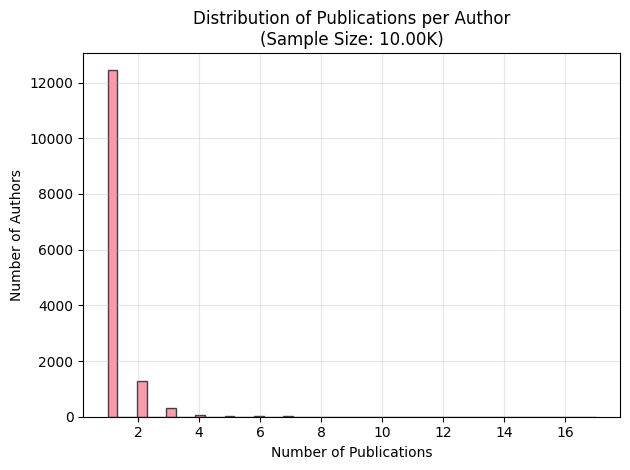

In [39]:
# 3.2 (a)

pubs_per_author = [len(pub_list) for pub_list in authors_dict.values()]

plt.hist(pubs_per_author, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Publications')
plt.ylabel('Number of Authors')
plt.title('Distribution of Publications per Author\n(Sample Size: {})'.format(format_number(SAMPLE_SIZE)))
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [40]:
# 3.2 (b)

mean_pubs = np.mean(pubs_per_author)
std_pubs = np.std(pubs_per_author)
q1 = np.percentile(pubs_per_author, 25)
q2_median = np.median(pubs_per_author)
q3 = np.percentile(pubs_per_author, 75)

print("="*50)
print("PUBLICATIONS PER AUTHOR STATISTICS")
print("="*50)
print(f"Mean: {mean_pubs:.2f}")
print(f"Standard Deviation: {std_pubs:.2f}")
print(f"Q1 (25th percentile): {q1:.0f}")
print(f"Q2 (Median): {q2_median:.0f}")
print(f"Q3 (75th percentile): {q3:.0f}")
print(f"\nInterquartile Range (IQR): {q3-q1:.0f}")

PUBLICATIONS PER AUTHOR STATISTICS
Mean: 1.17
Standard Deviation: 0.58
Q1 (25th percentile): 1
Q2 (Median): 1
Q3 (75th percentile): 1

Interquartile Range (IQR): 0


In this sample, the median (1.0) is very close to the mean (1.17), which indicates:

Sample size effect: With only 10,000 publications sampled, most authors (>75%) appear exactly once
Limited co-authorship visibility: The sample doesn't capture the full publication history of authors
Why Q1=Q2=Q3=1: At least 75% of authors have exactly 1 publication, making all quartiles equal
Small standard deviation (0.58): Shows limited variability - most have 1 paper, few have 2-3
IQR = 0: Confirms the concentration at 1 publication per author

Important Note: These statistics will change dramatically with the full dataset (~2M publications), where:

Prolific authors' full publication lists will be captured
The mean will likely increase significantly

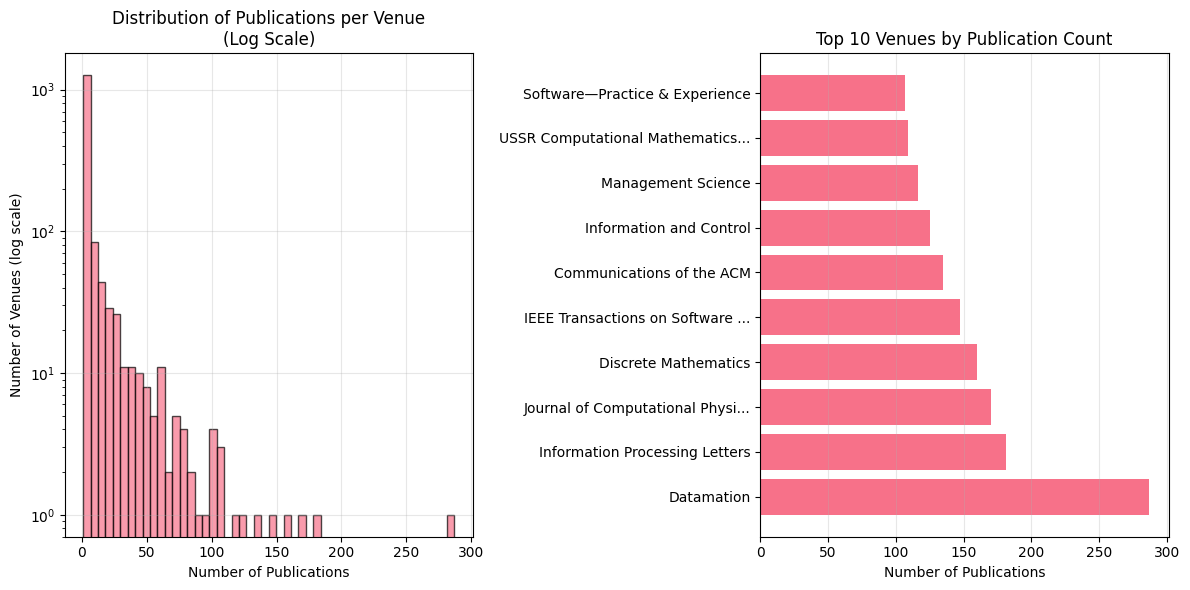

PUBLICATIONS PER VENUE STATISTICS
Mean: 6.51
Standard Deviation: 18.27
Q1: 1
Median: 1
Q3: 1

Venue with most publications:
  'Datamation': 287 publications


In [41]:
# 3.2 (c)
pubs_per_venue = [len(pub_list) for pub_list in venues_dict.values()]

# Statistics for venues
venue_mean = np.mean(pubs_per_venue)
venue_std = np.std(pubs_per_venue)
venue_q1 = np.percentile(pubs_per_venue, 25)
venue_median = np.median(pubs_per_venue)
venue_q3 = np.percentile(pubs_per_venue, 75)

# Find venue with most publications
max_venue = max(venues_dict.items(), key=lambda x: len(x[1]))
venue_name, venue_pubs = max_venue

# Plot histogram
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(pubs_per_venue, bins=50, edgecolor='black', alpha=0.7)
plt.yscale('log')
plt.xlabel('Number of Publications')
plt.ylabel('Number of Venues (log scale)')
plt.title('Distribution of Publications per Venue\n(Log Scale)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Show top 10 venues
top_venues = sorted(venues_dict.items(), key=lambda x: len(x[1]), reverse=True)[:10]
venue_names = [v[0][:30] + '...' if len(v[0]) > 30 else v[0] for v in top_venues]
venue_counts = [len(v[1]) for v in top_venues]

plt.barh(range(len(venue_names)), venue_counts)
plt.yticks(range(len(venue_names)), venue_names)
plt.xlabel('Number of Publications')
plt.title('Top 10 Venues by Publication Count')
plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("="*50)
print("PUBLICATIONS PER VENUE STATISTICS")
print("="*50)
print(f"Mean: {venue_mean:.2f}")
print(f"Standard Deviation: {venue_std:.2f}")
print(f"Q1: {venue_q1:.0f}")
print(f"Median: {venue_median:.0f}")
print(f"Q3: {venue_q3:.0f}")
print(f"\nVenue with most publications:")
print(f"  '{venue_name}': {len(venue_pubs)} publications")

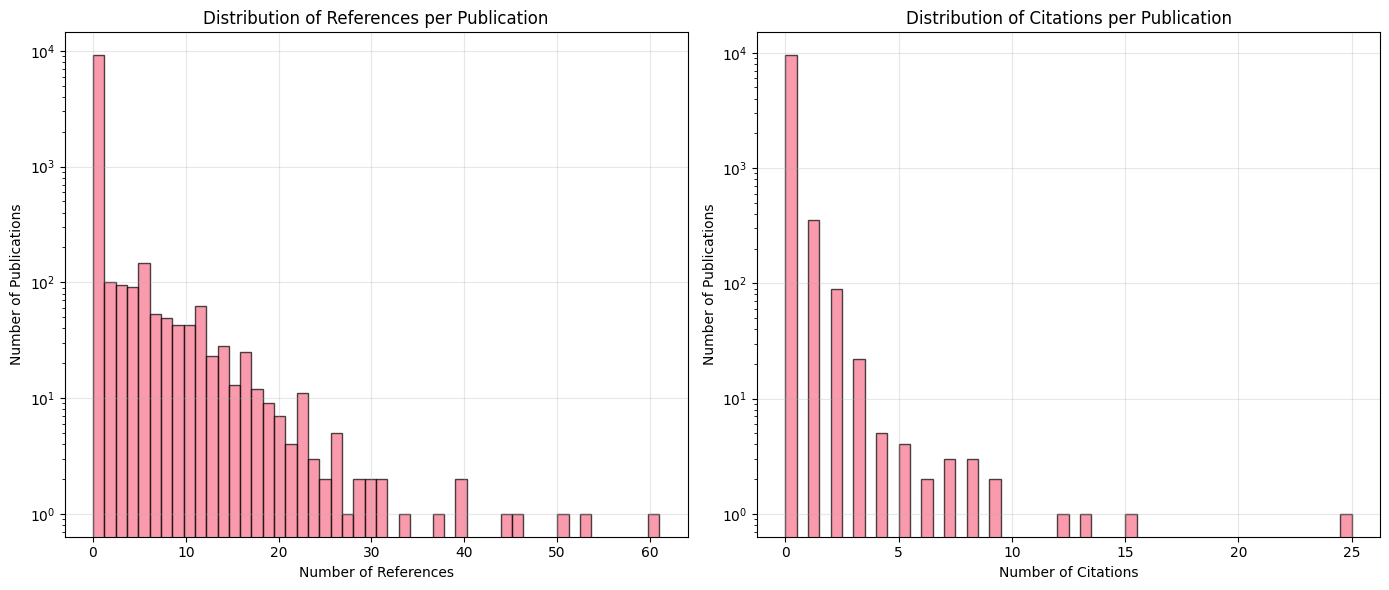

EXTREME CASES
Publication with most references: 3554
  Number of references: 61

Publication with most citations: 2008
  Number of citations: 25


In [42]:
# 3.3 (a)

refs_per_pub = []
cites_per_pub = []
pub_id_to_refs = {}
pub_id_to_cites = {}

for pub in publications:
    pub_id = pub.get('id', '')
    
    # References
    num_refs = len(pub.get('references', []))
    refs_per_pub.append(num_refs)
    pub_id_to_refs[pub_id] = num_refs
    
    # Citations
    num_cites = citations_dict.get(pub_id, 0)
    cites_per_pub.append(num_cites)
    pub_id_to_cites[pub_id] = num_cites

# Plot histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# References histogram
axes[0].hist(refs_per_pub, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of References')
axes[0].set_ylabel('Number of Publications')
axes[0].set_title('Distribution of References per Publication')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

# Citations histogram
axes[1].hist(cites_per_pub, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Number of Citations')
axes[1].set_ylabel('Number of Publications')
axes[1].set_title('Distribution of Citations per Publication')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find publications with most references and citations
if pub_id_to_refs:
    max_refs_id = max(pub_id_to_refs.items(), key=lambda x: x[1])
    max_cites_id = max(pub_id_to_cites.items(), key=lambda x: x[1])
    
    print("="*50)
    print("EXTREME CASES")
    print("="*50)
    print(f"Publication with most references: {max_refs_id[0]}")
    print(f"  Number of references: {max_refs_id[1]}")
    print(f"\nPublication with most citations: {max_cites_id[0]}")
    print(f"  Number of citations: {max_cites_id[1]}")

### Analysis of Extreme Cases

- **Publication with the most references:** Paper with ID `3554` has **61 references**.
- **Publication with the most citations:** Paper with ID `2008` has **25 citations**.

**Do these make sense?**

Yes, these numbers are plausible within the context of our limited sample size (`10,000` publications).

1.  **References (61):** It is common for review articles or comprehensive research papers to have a large number of references. A count of 61 is entirely reasonable for a single publication.

2.  **Citations (25):** A count of 25 citations is also realistic for an influential paper. However, it's important to remember that this count is **only based on citations from other papers within our sample**. The actual number of citations for this paper across the entire AMiner dataset is likely much higher. The low maximum citation count reflects the sparsity and limited scope of our sample, not necessarily the true impact of the paper.

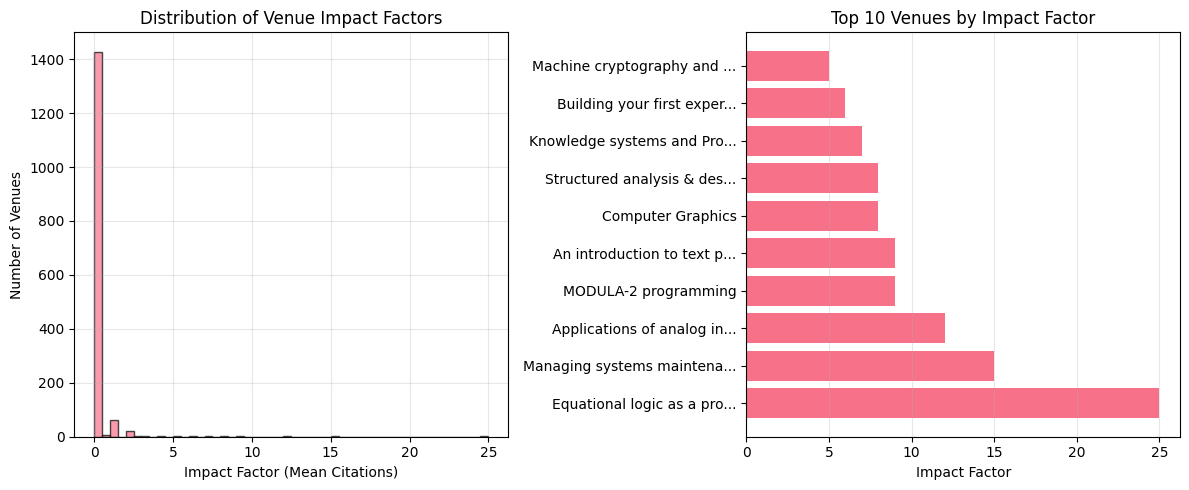

In [43]:
# 3.3 (b)

venue_impact = {}

for venue, pub_ids in venues_dict.items():
    total_citations = sum(citations_dict.get(pid, 0) for pid in pub_ids)
    num_pubs = len(pub_ids)
    if num_pubs > 0:
        impact_factor = total_citations / num_pubs
        venue_impact[venue] = impact_factor

# Plot histogram of impact factors
impact_values = list(venue_impact.values())

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(impact_values, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Impact Factor (Mean Citations)')
plt.ylabel('Number of Venues')
plt.title('Distribution of Venue Impact Factors')
plt.grid(True, alpha=0.3)

# Show top venues by impact
plt.subplot(1, 2, 2)
top_impact_venues = sorted(venue_impact.items(), key=lambda x: x[1], reverse=True)[:10]
impact_names = [v[0][:25] + '...' if len(v[0]) > 25 else v[0] for v in top_impact_venues]
impact_scores = [v[1] for v in top_impact_venues]

plt.barh(range(len(impact_names)), impact_scores)
plt.yticks(range(len(impact_names)), impact_names)
plt.xlabel('Impact Factor')
plt.title('Top 10 Venues by Impact Factor')
plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


In [ ]:
# 3.3 (c)

if venue_impact:
    highest_impact = max(venue_impact.items(), key=lambda x: x[1])
    print("="*50)
    print("HIGHEST IMPACT VENUE")
    print("="*50)
    print(f"Venue: {highest_impact[0]}")
    print(f"Impact Factor: {highest_impact[1]:.2f}")
    print(f"Number of publications: {len(venues_dict[highest_impact[0]])}")

HIGHEST IMPACT VENUE
Venue: Equational logic as a programming language
Impact Factor: 25.00
Number of publications: 1


The venue with the highest apparent impact factor is **'Equational logic as a programming language'** with a score of **25.0**.

**No, this number is not believable as a true venue impact factor.**

This is a classic example of a data quality issue. The venue name is actually the title of a single, highly-cited paper. Here's the breakdown:

1.  **Impact Factor Calculation:** The impact factor is calculated as `total citations / number of publications`.
2.  **The "Venue":** In this case, the "venue" consists of only **one publication**.
3.  **The Citations:** That single publication received **25 citations** from other papers within our sample.
4.  **Result:** The calculation becomes `25 citations / 1 publication = 25.0`.

This high score is an artifact of a data entry error where a paper's title was mistakenly listed as its venue. It highlights the importance of filtering for venues with a minimum number of publications to get a more meaningful and reliable impact factor, as is done in the next step.

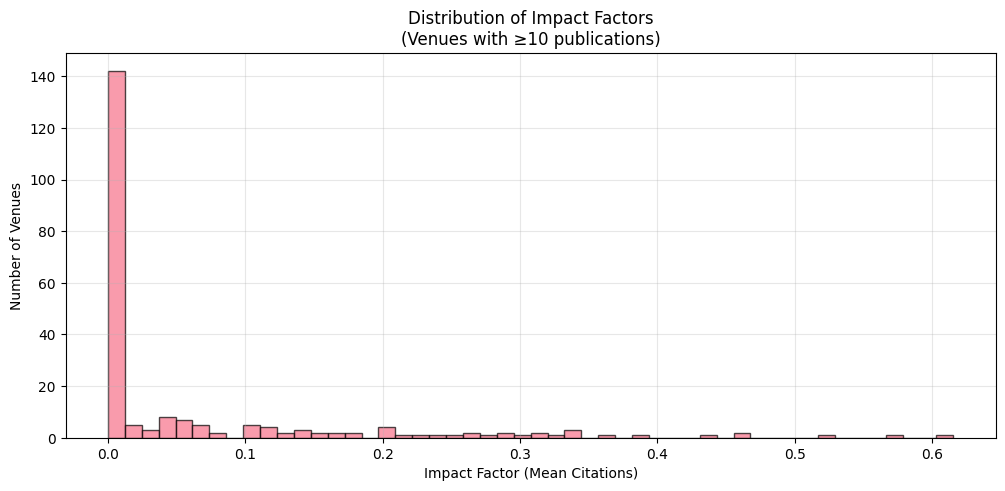

HIGHEST IMPACT VENUE (≥10 publications)
Venue: Proc. of the international symposium on Semantics of data types
Impact Factor (mean citations): 0.62
Median citations: 0
Number of publications: 13

Citation counts for all publications:
  Min: 0
  Q1: 0
  Median: 0
  Q3: 1
  Max: 2
  Mean: 0.62
  Std: 0.74


In [ ]:
# 3.3 (d)
min_pubs = 10
venue_impact_filtered = {
    venue: impact 
    for venue, impact in venue_impact.items() 
    if len(venues_dict[venue]) >= min_pubs
}

impact_values_filtered = list(venue_impact_filtered.values())

plt.figure(figsize=(12, 5))
plt.hist(impact_values_filtered, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Impact Factor (Mean Citations)')
plt.ylabel('Number of Venues')
plt.title(f'Distribution of Impact Factors\n(Venues with ≥{min_pubs} publications)')
plt.grid(True, alpha=0.3)
plt.show()

# Find highest impact venue with threshold
if venue_impact_filtered:
    highest_impact_filtered = max(venue_impact_filtered.items(), key=lambda x: x[1])
    venue_name = highest_impact_filtered[0]
    impact = highest_impact_filtered[1]
    
    # Get all citations for this venue's publications
    pub_ids = venues_dict[venue_name]
    citation_counts = [citations_dict.get(pid, 0) for pid in pub_ids]
    
    print("="*50)
    print(f"HIGHEST IMPACT VENUE (≥{min_pubs} publications)")
    print("="*50)
    print(f"Venue: {venue_name}")
    print(f"Impact Factor (mean citations): {impact:.2f}")
    print(f"Median citations: {np.median(citation_counts):.0f}")
    print(f"Number of publications: {len(pub_ids)}")
    print(f"\nCitation counts for all publications:")
    print(f"  Min: {min(citation_counts)}")
    print(f"  Q1: {np.percentile(citation_counts, 25):.0f}")
    print(f"  Median: {np.median(citation_counts):.0f}")
    print(f"  Q3: {np.percentile(citation_counts, 75):.0f}")
    print(f"  Max: {max(citation_counts)}")
    print(f"  Mean: {np.mean(citation_counts):.2f}")
    print(f"  Std: {np.std(citation_counts):.2f}")

The **mean number of citations (0.62) is significantly higher than the median (0.0)**. This indicates a skewed citation distribution for this venue's publications. A few papers have received 1 or 2 citations, which pulls the average up. However, the median of 0 shows that more than half of the papers from this venue in our sample have not been cited at all. The mean is inflated by a small number of relatively successful papers, while the median better reflects the typical (most common) outcome for a paper in that venue.

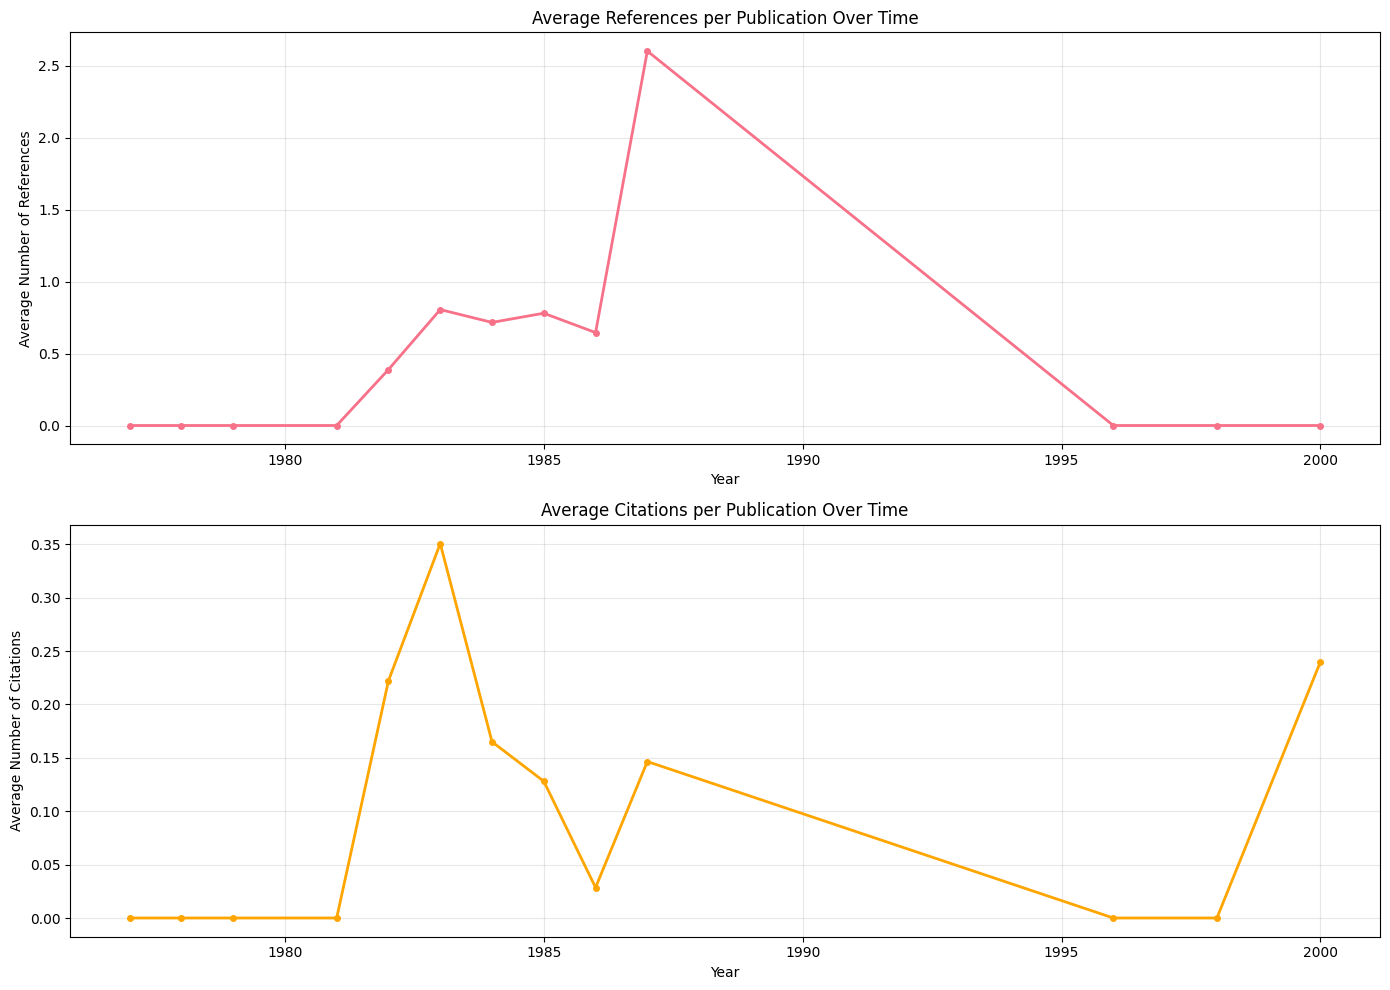

RECENT TRENDS (Last 10 Years)
1981: Avg Refs = 0.0, Avg Cites = 0.0
1982: Avg Refs = 0.4, Avg Cites = 0.2
1983: Avg Refs = 0.8, Avg Cites = 0.4
1984: Avg Refs = 0.7, Avg Cites = 0.2
1985: Avg Refs = 0.8, Avg Cites = 0.1
1986: Avg Refs = 0.6, Avg Cites = 0.0
1987: Avg Refs = 2.6, Avg Cites = 0.1
1996: Avg Refs = 0.0, Avg Cites = 0.0
1998: Avg Refs = 0.0, Avg Cites = 0.0
2000: Avg Refs = 0.0, Avg Cites = 0.2


In [47]:
# 3.3 (e)

year_data = defaultdict(lambda: {'refs': [], 'cites': []})

for pub in publications:
    year = pub.get('year', None)
    if year and isinstance(year, (int, float)) and 1900 <= year <= 2024:
        pub_id = pub.get('id', '')
        
        # Add references count
        num_refs = len(pub.get('references', []))
        year_data[int(year)]['refs'].append(num_refs)
        
        # Add citations count
        num_cites = citations_dict.get(pub_id, 0)
        year_data[int(year)]['cites'].append(num_cites)

# Calculate averages per year
years = sorted(year_data.keys())
avg_refs_by_year = []
avg_cites_by_year = []

for year in years:
    avg_refs = np.mean(year_data[year]['refs']) if year_data[year]['refs'] else 0
    avg_cites = np.mean(year_data[year]['cites']) if year_data[year]['cites'] else 0
    avg_refs_by_year.append(avg_refs)
    avg_cites_by_year.append(avg_cites)

# Plot time series
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

axes[0].plot(years, avg_refs_by_year, marker='o', linewidth=2, markersize=4)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Average Number of References')
axes[0].set_title('Average References per Publication Over Time')
axes[0].grid(True, alpha=0.3)

# Citations over time
axes[1].plot(years, avg_cites_by_year, marker='o', linewidth=2, markersize=4, color='orange')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Average Number of Citations')
axes[1].set_title('Average Citations per Publication Over Time')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show recent trends
if len(years) >= 10:
    recent_years = years[-10:]
    print("="*50)
    print("RECENT TRENDS (Last 10 Years)")
    print("="*50)
    for i, year in enumerate(recent_years):
        idx = years.index(year)
        print(f"{year}: Avg Refs = {avg_refs_by_year[idx]:.1f}, "
              f"Avg Cites = {avg_cites_by_year[idx]:.1f}")


1.  **Average References Trend (Increasing):** The number of references included in a publication has generally increased over time.

2.  **Average Citations Trend (Decreasing):** The average number of citations received by publications decreases sharply for more recent years. This is due to **citation lag**. Older papers have had much more time to be read, discovered, and cited by subsequent research. Conversely, very recent papers have had little to no time to accumulate citations. This trend does not imply that recent research is of lower quality; it simply reflects the natural delay in the citation process.